In [208]:
from __future__ import division
import numpy as np
from numpy.random import choice, normal, multivariate_normal
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
import csv
def read_data(file_path):
    # The read-in data should be a N*W matrix,
    # where N is the length of the time sequences,
    # W is the number of sensors/data features
    i = 0
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter = ',')
        for line in reader:
            line = np.array(line, dtype = 'float') # str2float
            if i == 0:
                data = line
            else:
                data = np.vstack((data, line))
            i += 1
    return data

<function matplotlib.pyplot.show>

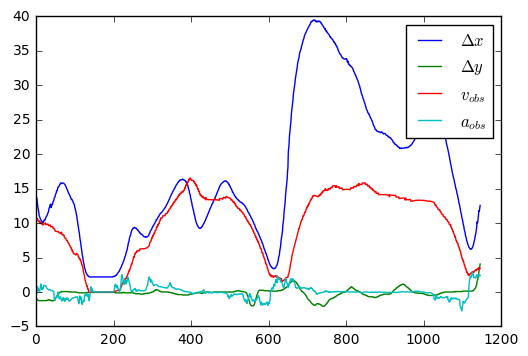

In [220]:
%matplotlib inline
# data_path = "four_scores.csv"
# data_path = "Brightness_features.csv"
# data_path = "obs_data_16d.csv"
# data_path = "ego_data_20d.csv"
data_path = "train_data.csv"
data = read_data(data_path)
data = data[:,3:7]#data[15500:16500,0:1] #data[8000:8500,[0,9]]
n,d = data.shape
plt.figure(1)
plt.plot(range(data.shape[0]),data)
plt.legend([r'$\Delta x$', r'$\Delta y$', r'$v_{obs}$', r'$a_{obs}$'])
plt.show
# normalize
# for i in range(d):
#     if np.std(data[:,i]) != 0:
#         data[:,i] = (data[:,i]-np.mean(data[:,i]))/np.std(data[:,i])
#     else:
#         data[:,i]    
# plt.figure(2)
# plt.plot(range(data.shape[0]),data)
# plt.show

# load test data
data_path = "test_data.csv"
data = read_data(data_path)
data = data[:,3:7]#data[15500:16500,0:1] #data[8000:8500,[0,9]]
n,d = data.shape
plt.figure(2)
plt.plot(range(data.shape[0]),data)
plt.legend([r'$\Delta x$', r'$\Delta y$', r'$v_{obs}$', r'$a_{obs}$'])
plt.show


In [221]:
class HMM():
    def __init__(self,data,K=10,model='Gaussian',kmeans_init=False):
        self.K = K # hmm state space size
        self.n,self.d = data.shape
        self.state_list = np.arange(self.K)
        self.data = data # training data
        
        # initialize parameters
        self.pi0 = np.ones(self.K)*1/self.K # first state prior, a (K,) array
        
        if kmeans_init:
            self.state = kmeans2(self.data, self.K)[1]
        else:
            self.state = choice(self.K,self.n)
        self.model = model # observation model
        if self.model == 'Gaussian':
            # compute parameter for each cluster
            self.mu = []
            self.sigma = []
            for k in range(self.K):
                idx = np.where(self.state==k)[0] # multi variable
                nc = len(idx)
                if nc:# multi variable
                    cluster = np.reshape(self.data[idx,:],(nc,self.d))
                    self.mu.append(np.mean(cluster,0)) # multi variable
                    if nc > 1:
                        self.sigma.append(np.cov(cluster,rowvar=False)) # multi variable
                    else:
                        self.sigma.append(np.eye(self.d))
                else:
                    cluster = []
                    self.mu.append(multivariate_normal(np.zeros(self.d), np.eye(self.d))) # multi variable
                    self.sigma.append(np.eye(self.d)) # multi variable
        self.log_like_matrix = np.zeros([self.n, self.K])
        # transition model 
        self.N = np.zeros((self.K, self.K))
        for n in range(1, self.n):
            self.N[self.state[n-1], self.state[n]] += 1
        self.A = (self.N.T/(np.sum(self.N, axis=1)+1e-7)).T
        
    def train(self, num_iter,converge_thresh):
        prevQ = -1e20
        i = 0
        while i < num_iter:
            self.log_like_matrix = self.log_likelihood_matrix(self.data)

            self.alpha,self.beta = self.forward_backward_algorithm()

            self.E_step()

            Q = self.check_log_likelihood()

            self.M_step()

            if Q < prevQ:
                print('warning: the log-likelihood is increasing')
            
            print ('log-likelihood: ', Q)
            if Q - prevQ < converge_thresh:
                break
            prev_Q = Q
            i += 1
    
    def test(self,test_data):
        log_like_matrix = self.log_likelihood_matrix(test_data)
        states =  np.argmax(log_like_matrix,axis=1)
        for n in range(1,len(states)):
            p_trans = self.A[states[n-1], states[n]]
            print ("p_trans", p_trans)
        
    def E_step(self):
        pX = np.reshape(np.sum(self.alpha*self.beta,axis=1),(self.n,1)) 
        
        self.gamma = self.alpha*self.beta/pX # n * k matrix
        
        self.xi = np.zeros([self.n-1, self.K, self.K]) # n-1 * k * k matrix
        for n in range(1,self.n):
            
            xi_num = (np.dot(np.reshape(self.alpha[n-1,:],(self.K,1)),
                             np.reshape(np.exp(self.log_like_matrix[n,:]) * self.beta[n,:], (1,self.K))) *\
                                  self.A)
            xi_den = np.sum(np.sum(xi_num,axis=1))
            self.xi[n-1,:,:] = xi_num/xi_den
        
    def M_step(self):
        # update first state prior
        self.pi0 = self.gamma[0,:]/np.sum(self.gamma[0,:])
        
        # update transition model
        A_num = np.sum(self.xi, axis=0)
        A_den = np.reshape(np.sum(A_num,axis=1),(self.K,1))
        self.A = A_num/A_den
        
        # update emission model
        if self.model == 'Gaussian':
            for k in range(self.K):
                mu_num = np.sum(np.reshape(self.gamma[:,k],(self.n,1)) * self.data, axis=0) # (d,) matrix
                mu_den = np.sum(self.gamma[:,k])# scalar
                self.mu[k] = mu_num/mu_den

                sigma_num = np.dot((self.data-self.mu[k]).T, np.reshape(self.gamma[:,k],(self.n,1))*(self.data-self.mu[k]))
                sigma_den = mu_den
                self.sigma[k] = sigma_num/sigma_den
            
    def forward_backward_algorithm(self):
        # forward
        alpha = np.zeros((self.n, self.K))
        alpha[0, :] = self.pi0*np.exp(self.log_like_matrix[0,:])#1
        for t in range(1, self.n):
            alpha[t,:] = (self.A.T.dot(alpha[t-1,:])) * np.exp(self.log_like_matrix[t,:])
            alpha[t, :] /= np.max(alpha[t, :])
        # backward
        beta = np.zeros((self.n, self.K))
        beta[-1, :] = 1
        for t in range(self.n - 1, 0, -1):

            beta[t-1, :] = self.A.dot(beta[t, :] * np.exp(self.log_like_matrix[t,:]))
            beta[t-1, :] /= np.max(beta[t-1, :])            
        return alpha, beta
    
    def log_likelihood_matrix(self,data):
        '''
        Likelihood matrix of all observations, each row is the likelihood of one data given all possible states.
        Output: log-likelihood matrix with size self.n*K
        '''
        N,d = data.shape
        log_like_matrix = np.zeros([N,self.K])
        for n in range(N):
            for k in range(self.K):
                diff = data[n,:]-self.mu[k]
                sigma = self.sigma[k]
                log_like_matrix[n,k] = (-1/2) * np.dot(np.dot(diff, np.linalg.pinv(sigma)), diff.T) - np.log(np.sqrt(np.linalg.det(2*np.pi*sigma)))
        return log_like_matrix

    def check_log_likelihood(self):
        idx = np.where(self.pi0!=0)[0]
        term1 = np.dot(self.gamma[0,idx],np.log(self.pi0[idx]))
        term2 = 0
        idx = np.where(hmm.A!=0)
        for n in range(1,self.n):
            xi = self.xi[n-1,:,:]
            term2 += np.sum(np.sum(xi[idx]*np.log(self.A[idx])))
        term3 = np.sum(np.sum(self.gamma * self.log_like_matrix))
        
        print term1
        print term2
        print term3
        return term1+term2+term3

In [202]:
hmm = HMM(data)

In [203]:

num_iter = 20
converge_thresh = 1e-5
hmm.train(num_iter, converge_thresh)

-2.30258509299
-2557.10075075
-9611.4041109
('log-likelihood: ', -12170.807446746838)
-2.28624712926
-2121.07690907
-8604.35115887
('log-likelihood: ', -10727.714315062054)
-2.14643259832
-1283.54415002
-7363.30254727
('log-likelihood: ', -8648.9931298864631)
-1.63427567536
-692.633169364
-6408.70301022
('log-likelihood: ', -7102.9704552592957)
-0.845981960993
-310.544066586
-5488.02981412
('log-likelihood: ', -5799.4198626638718)
-0.589966571616
-175.997249365
-4698.96807452
('log-likelihood: ', -4875.5552904595143)
-0.000425373919983
-207.121494429
-4248.12057397
('log-likelihood: ', -4455.2424937764035)
-3.33441631979e-11
-125.259218269
-4023.6339
('log-likelihood: ', -4148.8931182732413)
-1.1102236522e-16
-122.235074621
-3894.15836734
('log-likelihood: ', -4016.3934419637599)
-2.96799530453e-29
-120.417282993
-3857.71179535
('log-likelihood: ', -3978.1290783400577)
-1.34779314453e-35
-117.772443053
-3841.11033403
('log-likelihood: ', -3958.8827770800467)
-5.38431274165e-42
-118.188

<function matplotlib.pyplot.show>

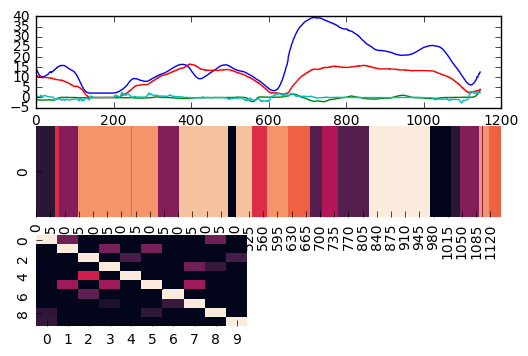

In [217]:
states = np.argmax(hmm.log_like_matrix,axis=1)
plt.figure(2)
plt.subplot(311)
plt.plot(range(hmm.n),data)
plt.subplot(312)
sns.heatmap(np.reshape(states,(1,hmm.n)), cbar=False)
plt.subplot(325)
sns.heatmap(hmm.A, vmin=0, vmax=0.05, cbar=False)
plt.show

In [165]:
np.reshape(np.sum(hmm.alpha*hmm.beta,axis=1),(self.n,1))

array([[  6.32801086e-151,   2.88582664e-012,   5.31307473e-004, ...,
          1.00000000e+000,   5.83236227e-058,   4.26326796e-011],
       [  1.72208426e-145,   5.61491658e-014,   4.97949052e-004, ...,
          1.00000000e+000,   6.82698816e-068,   2.58151658e-016],
       [  3.63079770e-174,   2.72365976e-018,   4.97948850e-004, ...,
          1.00000000e+000,   1.08231670e-081,   1.43743919e-026],
       ..., 
       [  0.00000000e+000,   1.57553083e-134,   4.97948850e-004, ...,
          1.00000000e+000,   4.21215513e-128,   1.56443621e-034],
       [  0.00000000e+000,   2.20493640e-133,   4.97948850e-004, ...,
          1.00000000e+000,   5.89486032e-127,   2.18940961e-033],
       [  1.00000000e+000,   1.00000000e+000,   1.00000000e+000, ...,
          1.00000000e+000,   1.00000000e+000,   1.00000000e+000]])